# Predicting heart rate during excercise with LSTM

Training a LSTM model by reading decoded fit files. Inputs from the previous 60sec are:
- heart rate
- cadence
- speed
- altitude (however, transformed into difference between 1 second samples and then 5sec moving average)


In [150]:
# load libraries
import os, glob 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

model_features =  ["heart_rate", "cadence","enhanced_speed","rolling_ave_alt"]
fit_path = "/home/riku/projects/athlet_hr_predict/fit_file_csv"
os.chdir(fit_path)

In [151]:
# add calculated altitude difference column, and 5sec moving average of it
fit_files = glob.glob("*.csv")
for file in fit_files:
    df = pd.read_csv(fit_path+'/'+file, index_col='timestamp')
    df['alt_difference'] = df['enhanced_altitude'] - df['enhanced_altitude'].shift(1)
    df['rolling_ave_alt'] = df['alt_difference'].rolling(window=5).mean()
    df = df.bfill()
    df.to_csv(fit_path+'/'+file)


In [152]:
# set parameters, file names
n_X = 60 # number of timesteps for training
n_y = 30 # number of timesteps in future for prediction
step = 1
batch_size = 10
epochs = 100 # maximum number of epochs - autostop will work on per file basis
learning_rate = 0.001
sequence_length = int(n_X/step)
n_fit_files_test_set = 1 # number of files for validation dataset (only 1 validation file supported at the moment)

# select the training files and the validation files 
train_files = glob.glob("*.csv")[0:-n_fit_files_test_set]
valid_files = glob.glob("*.csv")[-n_fit_files_test_set:]

In [153]:
# calculate the data normalisation parameters from all training data

def normalize(data):
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    #return (data - data_mean) / data_std, data_mean, data_std
    return data_mean, data_std

li = []

for file in train_files:
    df = pd.read_csv(fit_path+'/'+file, index_col='timestamp')[model_features]
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

df_mean, df_std = normalize(df)

def denormalize_hr(data):
    return data*df_std[0]+df_mean[0] 

## short EDA

The fit file chosen here represents a hilly run and it shows large variability during the workout in heart rate, speed and altitude. Cadence is relatively constant throughout the excercise.

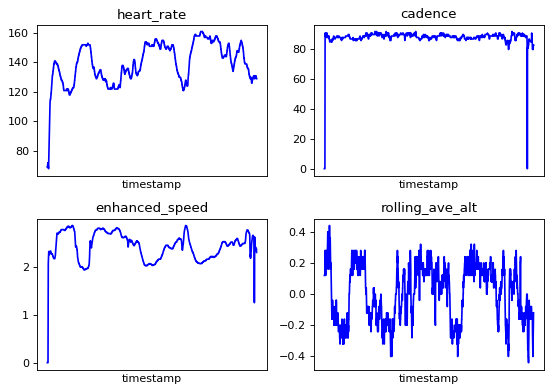

In [154]:
eda_example = pd.read_csv(fit_path+'/RUN_2021-08-26-07-15-23.fit.csv', index_col='timestamp')[model_features]

def show_raw_visualization(data):
    time_data = data.index
    fig, axes = plt.subplots(
        nrows=2, ncols=2, figsize=(7, 5), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(4):
        key = model_features[i]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color='b',
            title="{}".format(key),
            rot=25,
        )
        ax.set_xticks([])
    plt.tight_layout()

show_raw_visualization(eda_example)


## Create validation dataset

In [155]:
# validation dataset - train each file at the time

for file in train_files:
    df = pd.read_csv(fit_path+'/'+file, index_col='timestamp')[model_features]
    df = (df - df_mean) / df_std
    start = n_X + n_y
    end = n_X + len(df.index)
    
    x = df[model_features].values
    y = df.iloc[start:end][["heart_rate"]]
    
    dataset_val = keras.preprocessing.timeseries_dataset_from_array(
        x,
        y,
        sequence_length=sequence_length,
        sampling_rate=step,
        batch_size=batch_size,
    )

## Build the model

In [156]:
# get the shapes of X & y for a batch
for batch in dataset_val.take(1):
    inputs, targets = batch

# the model
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(4, return_sequences=True)(inputs)
#lstm_out = keras.layers.LSTM(4)(inputs)

lstm_out = keras.layers.LSTM(4)(lstm_out)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 60, 4)]           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 4)             144       
_________________________________________________________________
lstm_3 (LSTM)                (None, 4)                 144       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 293
Trainable params: 293
Non-trainable params: 0
_________________________________________________________________


## Load the training data, train the model file by file

Each file is processed separately, and training epochs repeated as long as the model improves for each model up to the variable $epochs$ defined earlier. 

In [157]:
# training dataset, and train each file at the time

def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

for file in train_files:
    df = pd.read_csv(fit_path+'/'+file, index_col='timestamp')[model_features]
    df = (df - df_mean) / df_std
    print(file)
    start = n_X + n_y
    end = n_X + len(df.index)
    
    x = df[model_features].values
    y = df.iloc[start:end][["heart_rate"]].values
    
    dataset_train = keras.preprocessing.timeseries_dataset_from_array(
        x,
        y,
        sequence_length=sequence_length,
        sampling_rate=step,
        batch_size=batch_size,
    )
    
    history = model.fit(
        dataset_train,
        epochs=epochs,
        validation_data=dataset_val,
        callbacks=[es_callback, modelckpt_callback],
        verbose=0
    )

    #visualize_loss(history, "Training and Validation Loss")


RUN_2021-09-01-09-09-44.fit.csv

Epoch 00001: val_loss improved from inf to 0.77042, saving model to model_checkpoint.h5

Epoch 00002: val_loss improved from 0.77042 to 0.63575, saving model to model_checkpoint.h5

Epoch 00003: val_loss improved from 0.63575 to 0.48134, saving model to model_checkpoint.h5

Epoch 00004: val_loss improved from 0.48134 to 0.39235, saving model to model_checkpoint.h5

Epoch 00005: val_loss improved from 0.39235 to 0.33746, saving model to model_checkpoint.h5

Epoch 00006: val_loss improved from 0.33746 to 0.30118, saving model to model_checkpoint.h5

Epoch 00007: val_loss improved from 0.30118 to 0.27679, saving model to model_checkpoint.h5

Epoch 00008: val_loss improved from 0.27679 to 0.26007, saving model to model_checkpoint.h5

Epoch 00009: val_loss improved from 0.26007 to 0.24846, saving model to model_checkpoint.h5

Epoch 00010: val_loss improved from 0.24846 to 0.24030, saving model to model_checkpoint.h5

Epoch 00011: val_loss improved from 0.240

## Visualise the training for the last file

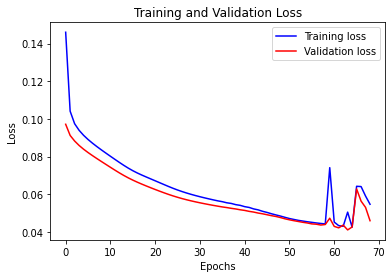

In [158]:
visualize_loss(history, "Training and Validation Loss")

## Check the model predictions visually

In [159]:
    # create test set from a file not used for training or validation during the parameters tuning
    
    df_test = pd.read_csv(fit_path+'/../RUN_2021-08-05-11-12-41.fit.csv', index_col='timestamp')[model_features]
    df_test = (df_test - df_mean) / df_std
   
    x = df_test[model_features].values
    y = df_test.iloc[start:end][["heart_rate"]].values

    dataset_test = keras.preprocessing.timeseries_dataset_from_array(
    x,
    y,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=120)



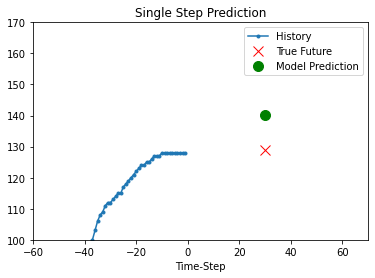

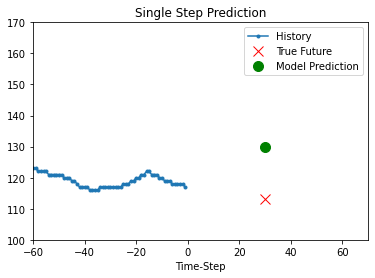

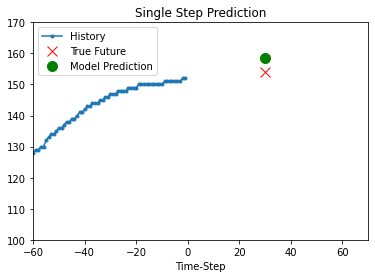

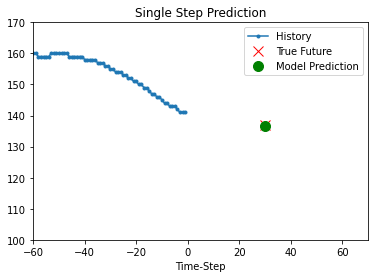

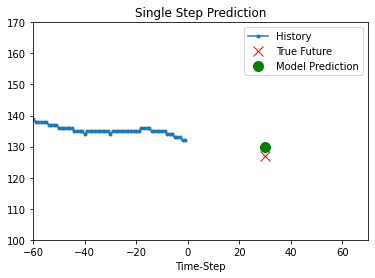

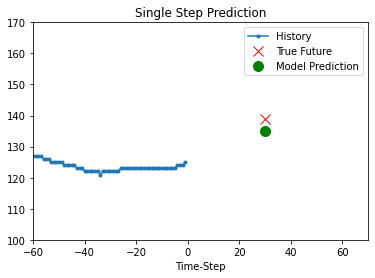

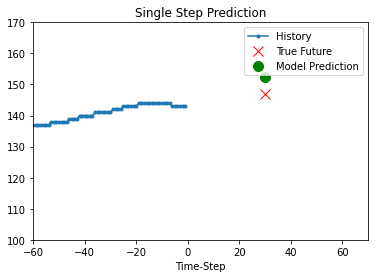

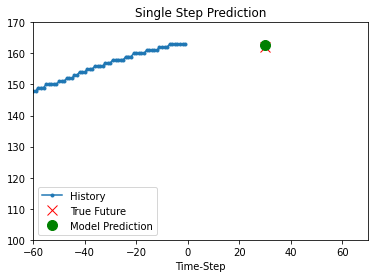

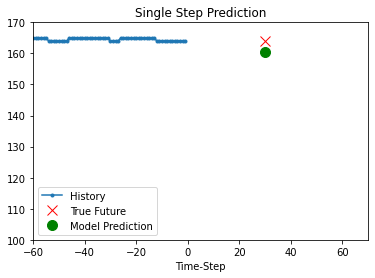

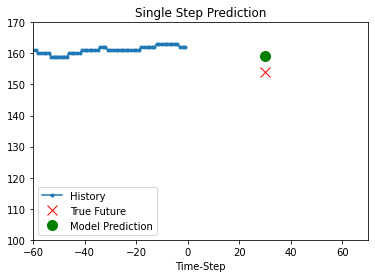

In [160]:


def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))

    if delta:
        future = delta
    else:
        future = 0
    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.ylim(100,170)
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_test.take(10):
    show_plot(
        [denormalize_hr(x[0][:, 0].numpy()), denormalize_hr(y[0]), denormalize_hr( model.predict(x)[0])],
        30,
        "Single Step Prediction",
    )

## Analyse results 

under construction

In [161]:
    # create test set from a file not used for training or validation during the parameters tuning
    
    df_test = pd.read_csv(fit_path+'/../RUN_2021-08-05-11-12-41.fit.csv', index_col='timestamp')[model_features]
    df_test = (df_test - df_mean) / df_std
   
    x = df_test[model_features].values
    y = df_test.iloc[start:end][["heart_rate"]].values

    dataset_test = keras.preprocessing.timeseries_dataset_from_array(
    x,
    y,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=2)

    

In [162]:
d=pd.DataFrame([0,1])
for x, y in dataset_test:
    a = denormalize_hr(y[0]).numpy(), denormalize_hr( model.predict(x)[0])
    c = pd.DataFrame(a).T
    d = d.merge(c, how='outer')
d.columns=['measured', 'predicted']

<AxesSubplot:>

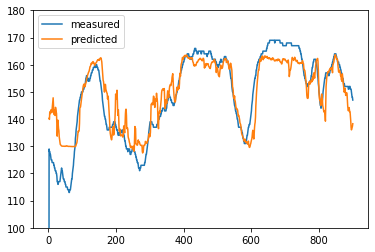

In [163]:
d.plot(ylim=(100,180))

AttributeError: module 'matplotlib.pyplot' has no attribute 'ylabe'

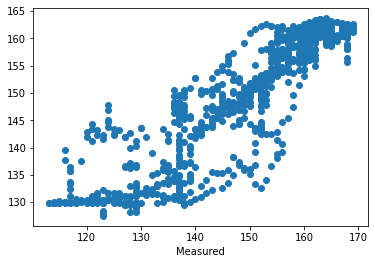

In [164]:
plt.scatter(d['measured'], d['predicted'])
plt.xlabel('Measured')
plt.ylabe('Predicted')
